In [19]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import pandas as pd
import os
import numpy as np
import pylab as plt
from pesummary.gw.conversions.spins import spin_angles
import bilby
import sys
import pesummary
from pesummary.utils.samples_dict import SamplesDict
import sys

## Parameters

In [33]:
param_dict = {
    'mass_1': 101.074872,
    'mass_2': 92.346816,
    'luminosity_distance': 1338.594547,
    'theta_jn': 1.985243,
    'ra': 3.911826,
    'dec': -0.785394,
    'psi': 2.725428,
    'geocent_time': 1.898149e9,
    'phase': 2.925349,
    'a_1': 0.381862,
    'a_2': 0.571084,
    'tilt_1': 2.586043,
    'tilt_2': 2.641905,
    'phi_12': 0.402861,
    'phi_jl': 5.313141
}
approx = 'IMRPhenomXPHM'
delta_f = 1./100,
f_low = 10
f_ref = f_low
f_high = 2048

In [34]:
samples = SamplesDict({key:[val] for key, val in param_dict.items()})
samples.generate_all_posterior_samples(delta_f = delta_f, f_start = f_low, f_low=f_low, f_ref=f_ref, f_final=f_high)
samples

2025-08-29  21:30:01 PESummary WARNING : The redshift is being approximated using interpolation. Bear in mind that this does introduce a small error.
2025-08-29  21:30:01 PESummary INFO    : Averaging the final spin from the following fits: function bbh_final_spin_precessing_projected_UIB2016 at 0x7490af73c2c0, function bbh_final_spin_precessing_projected_Healyetal at 0x7490af73c860, function bbh_final_spin_precessing_HBR2016 at 0x7490af73c360
2025-08-29  21:30:01 PESummary INFO    : Averaging the peak luminosity from the following fits: function bbh_peak_luminosity_non_precessing_UIB2016 at 0x7490af73e8e0, function bbh_peak_luminosity_non_precessing_Healyetal at 0x7490af73e980
2025-08-29  21:30:01 PESummary INFO    : Averaging the final mass from the following fits: function bbh_final_mass_non_precessing_UIB2016 at 0x7490af73d120, function bbh_final_mass_non_precessing_Healyetal at 0x7490af7318a0


{'mass_1': Array([101.074872]),
 'mass_2': Array([92.346816]),
 'luminosity_distance': Array([1338.594547]),
 'theta_jn': Array([1.985243]),
 'ra': Array([3.911826]),
 'dec': Array([-0.785394]),
 'psi': Array([2.725428]),
 'geocent_time': Array([1.898149e+09]),
 'phase': Array([2.925349]),
 'a_1': Array([0.381862]),
 'a_2': Array([0.571084]),
 'tilt_1': Array([2.586043]),
 'tilt_2': Array([2.641905]),
 'phi_12': Array([0.402861]),
 'phi_jl': Array([5.313141]),
 'redshift': Array([0.25650865]),
 'comoving_distance': Array([1065.32855064]),
 'mass_ratio': Array([0.91364762]),
 'inverted_mass_ratio': Array([1.09451388]),
 'total_mass': Array([193.421688]),
 'chirp_mass': Array([84.08877812]),
 'symmetric_mass_ratio': Array([0.24949094]),
 'mass_1_source': Array([80.44104722]),
 'mass_2_source': Array([73.49477115]),
 'total_mass_source': Array([153.93581837]),
 'chirp_mass_source': Array([66.92256184]),
 'iota': Array([2.1138162]),
 'spin_1x': Array([0.12202995]),
 'spin_1y': Array([-0.16

## PyCBC

In [35]:
from pycbc.waveform import get_fd_waveform
from pycbc.detector import Detector
from pycbc.filter.matchedfilter import sigmasq
import pycbc

In [36]:
PyCBC_wf_gen_keys_map = {
    'mass_1':'mass1', 
    'mass_2':'mass2', 
    'luminosity_distance':'distance',
    'iota':'inclination',
    'geocent_time':'trigger_time',
    'phase':'coa_phase',
    'ra':'ra',
    'dec':'dec',
    'psi':'polarization',
    'spin_1x':'spin1x',
    'spin_1y':'spin1y',
    'spin_1z':'spin1z',
    'spin_2x':'spin2x',
    'spin_2y':'spin2y',
    'spin_2z':'spin2z'
}

In [37]:
PyCBC_samples = {PyCBC_wf_gen_keys_map[key]:samples[key] for key in PyCBC_wf_gen_keys_map.keys()}
PyCBC_samples

{'mass1': Array([101.074872]),
 'mass2': Array([92.346816]),
 'distance': Array([1338.594547]),
 'inclination': Array([2.1138162]),
 'trigger_time': Array([1.898149e+09]),
 'coa_phase': Array([2.925349]),
 'ra': Array([3.911826]),
 'dec': Array([-0.785394]),
 'polarization': Array([2.725428]),
 'spin1x': Array([0.12202995]),
 'spin1y': Array([-0.16021809]),
 'spin1z': Array([-0.32443403]),
 'spin2x': Array([0.23787037]),
 'spin2y': Array([-0.135256]),
 'spin2z': Array([-0.50125885])}

In [38]:
def calc_PyCBC_snr(params_dict, f_low, f_high):
    hp, hc = get_fd_waveform(**params_dict)
    dets = ['L1', 'H1', 'I1']
    hf = {}
    snrs = {}
    snr_sq_netw = 0
    for det in dets:
        fp, fc = Detector(det).antenna_pattern(params_dict['ra'], params_dict['dec'], params_dict['polarization'], params_dict['trigger_time'])
        hf[det] = hp*fp + hc*fc
        psd = pycbc.psd.read.from_txt('../noise_curves/Asharp-asd.txt', len(hf[det]), hf[det].delta_f, f_low)
        snr_sq = sigmasq(hf[det], psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)
        snrs[f'SNR_{det}'] = np.sqrt(snr_sq)
        snr_sq_netw += snr_sq
    snrs['SNR_network'] = np.sqrt(snr_sq_netw)
    return(hf, snrs)

In [39]:
PyCBC_samples_wf_gen = {key: PyCBC_samples[key][0] for key in PyCBC_wf_gen_keys_map.values()}
PyCBC_samples_wf_gen.update(approximant=approx, f_lower=f_low, delta_f=delta_f[0], f_ref=f_ref)
PyCBC_samples_wf_gen

{'mass1': 101.074872,
 'mass2': 92.346816,
 'distance': 1338.594547,
 'inclination': 2.1138161980601673,
 'trigger_time': 1898149000.0,
 'coa_phase': 2.925349,
 'ra': 3.911826,
 'dec': -0.785394,
 'polarization': 2.725428,
 'spin1x': 0.12202994926782969,
 'spin1y': -0.1602180936295745,
 'spin1z': -0.324434031814475,
 'spin2x': 0.23787036640856557,
 'spin2y': -0.13525600088430356,
 'spin2z': -0.5012588533536739,
 'approximant': 'IMRPhenomXPHM',
 'f_lower': 10,
 'delta_f': 0.01,
 'f_ref': 10}

In [40]:
pycbc_hfs, pycbc_snrs = calc_PyCBC_snr(PyCBC_samples_wf_gen, f_low=f_low, f_high=f_high)

In [41]:
pycbc_snrs

{'SNR_L1': 47.958314160034526,
 'SNR_H1': 43.79786213605386,
 'SNR_I1': 56.296546658342976,
 'SNR_network': 85.950880102628}

## Bilby

In [42]:
import bilby
bilby.core.utils.log.setup_logger(log_level="debug")

In [43]:
def calc_bilby_snr(injection_parameters):
    waveform_arguments = dict(
        waveform_approximant=approx,
        reference_frequency=f_low,
        minimum_frequency=f_low,
    )
    duration = 100
    # Create the waveform_generator using a LAL BinaryBlackHole source function
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration,
        sampling_frequency=4096,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments
    )
    
    ifos = bilby.gw.detector.InterferometerList(["L1", "H1", "A1"])
    ifos.set_strain_data_from_zero_noise(
        sampling_frequency=4096,
        duration=duration,
        start_time=injection_parameters["geocent_time"] - duration + 2,
    )
    
    for ifo in ifos:
        ifo.minimum_frequency = f_low
        ifo.power_spectral_density = bilby.gw.detector.psd.PowerSpectralDensity(psd_file='../noise_curves/Asharp-psd.txt')
    
    ifos.inject_signal(
        waveform_generator=waveform_generator, parameters=injection_parameters
    )

    snrdict_return = {}
    optsnrsquared = 0
    for ifo in ifos:
        det = ifo.name
        SNR = ifos.meta_data[det]["optimal_SNR"]
        snrdict_return[f'SNR_{det}'] = SNR
        optsnrsquared += SNR ** 2
    snrdict_return['SNR_network'] = np.sqrt(optsnrsquared)

    return snrdict_return, ifo

In [44]:
bilby_snr, ifo = calc_bilby_snr(param_dict)

21:30 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
21:30 bilby DEBUG   : PSD file set to None
21:30 bilby DEBUG   : PSD file aLIGO_O4_high_asd.txt exists in default dir.
21:30 bilby DEBUG   : Assuming L shape for name
21:30 bilby DEBUG   : PSD file set to None
21:30 bilby DEBUG   : PSD file aLIGO_O4_high_asd.txt exists in default dir.
21:30 bilby DEBUG   : Assuming L shape for name
21:30 bilby DEBUG   : PSD file set to None
21:30 bilby DEBUG   : PSD file Aplus_asd.txt exists in default dir.
21:30 bilby DEBUG   : Assuming L shape for name
21:30 bilby DEBUG   : Setting zero noise data
21:30 bilby DEBUG   : Setting zero noise data
21:30 bilby DEBUG   : Setting zero noise data
21:30 bilby DEBUG   : PSD file ../noise_curves/Asharp-psd.txt exists
21:30 bilby DEBUG   : PSD file set to None
21:30 bil

In [45]:
print('bilby: ', bilby_snr)
print('pycbc: ', pycbc_snrs)

bilby:  {'SNR_L1': 47.954553124888925, 'SNR_H1': 43.79356624792153, 'SNR_A1': 56.297022427614614, 'SNR_network': 85.94690421611607}
pycbc:  {'SNR_L1': 47.958314160034526, 'SNR_H1': 43.79786213605386, 'SNR_I1': 56.296546658342976, 'SNR_network': 85.950880102628}


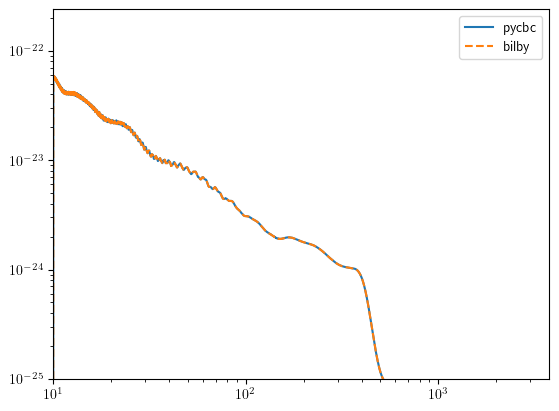

In [18]:
plt.loglog(pycbc_hfs['I1'].sample_frequencies, abs(pycbc_hfs['I1']), label='pycbc')
plt.loglog(ifo.frequency_array, abs(ifo.frequency_domain_strain), ls='--', label='bilby')
plt.xlim(10,)
plt.ylim(1e-25,)
plt.legend()